cpu
EPOCH :    100/ 20000 | Loss_ge : 0.3436731 | Loss_bdry : 0.0235855
EPOCH :    200/ 20000 | Loss_ge : 0.4539434 | Loss_bdry : 0.0020491
EPOCH :    300/ 20000 | Loss_ge : 0.4699718 | Loss_bdry : 0.0012405
EPOCH :    400/ 20000 | Loss_ge : 0.4715278 | Loss_bdry : 0.0011274
EPOCH :    500/ 20000 | Loss_ge : 0.4721598 | Loss_bdry : 0.0010445
EPOCH :    600/ 20000 | Loss_ge : 0.4727151 | Loss_bdry : 0.0009813
EPOCH :    700/ 20000 | Loss_ge : 0.4731361 | Loss_bdry : 0.0009365
EPOCH :    800/ 20000 | Loss_ge : 0.4733452 | Loss_bdry : 0.0009059
EPOCH :    900/ 20000 | Loss_ge : 0.4732986 | Loss_bdry : 0.0008851
EPOCH :   1000/ 20000 | Loss_ge : 0.4729931 | Loss_bdry : 0.0008701
EPOCH :   1100/ 20000 | Loss_ge : 0.4724573 | Loss_bdry : 0.0008581
EPOCH :   1200/ 20000 | Loss_ge : 0.4717345 | Loss_bdry : 0.0008476
EPOCH :   1300/ 20000 | Loss_ge : 0.4708687 | Loss_bdry : 0.0008377
EPOCH :   1400/ 20000 | Loss_ge : 0.4698989 | Loss_bdry : 0.0008281
EPOCH :   1500/ 20000 | Loss_ge : 0.4688549 

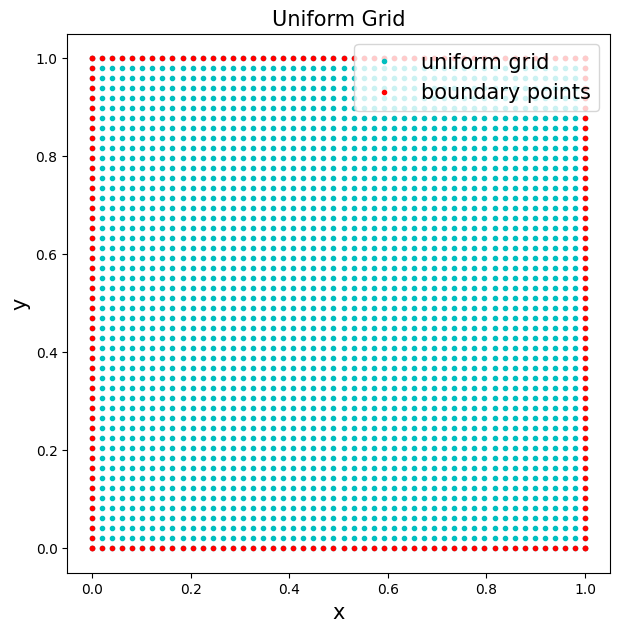

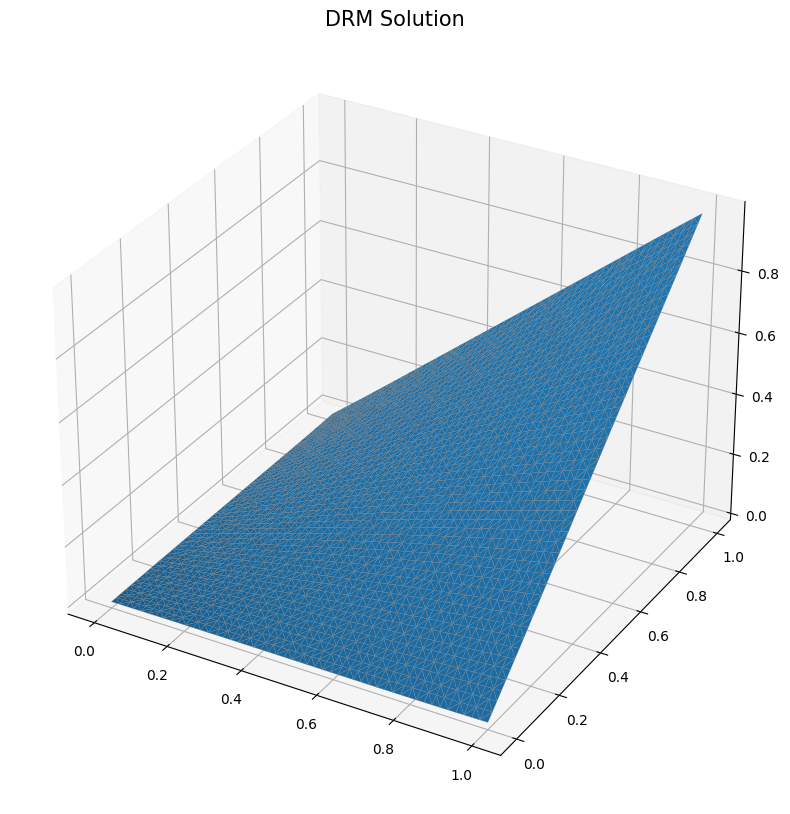

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd import Variable

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

Nx = 50                                                   # Number of samples
Ny = 50                                                   # Number of samples
x = torch.linspace(0, 1, Nx)                             # Input data for x (N x 1)
y = torch.linspace(0, 1, Ny)                             # Input data for y (N x 1)

xy = torch.meshgrid(x,y)
xy_grid = torch.cat([xy[0].reshape(-1,1), xy[1].reshape(-1,1)],dim=1)

x_bdry = xy_grid[torch.logical_or((xy_grid[:,0]==1), (xy_grid[:,0]==0))]
y_bdry = xy_grid[torch.logical_or((xy_grid[:,1]==1), (xy_grid[:,1]==0))]
xy_bdry = torch.cat([x_bdry, y_bdry])
u_bdry = (xy_bdry[:,0]*xy_bdry[:,1]).view(-1,1)

plt.figure(figsize=(7,7))
plt.plot(xy_grid[:,0], xy_grid[:,1], 'co', markersize=3, label='uniform grid')
plt.plot(xy_bdry[:,0], xy_bdry[:,1], 'ro', markersize=3, label='boundary points')
plt.legend(loc='upper right', fontsize=15)
plt.title('Uniform Grid', fontsize=15)
plt.xlabel('x', fontsize=15)
plt.ylabel('y', fontsize=15)
plt.savefig('drm_data')

# Build a neural network

class model(nn.Module) :
    def __init__(self, hidden_dims) :                    # Hidden_dims : [h1, h2, h3, ..., hn]
        super(model, self).__init__()

        self.layers = [nn.Linear(hidden_dims[0], hidden_dims[1])]
        for i in range(1,len(hidden_dims)-2) :
            self.layers.append(nn.Linear(hidden_dims[i], hidden_dims[i+1])) # hidden layers
            self.layers.append(nn.Linear(hidden_dims[i], hidden_dims[i+1])) # hidden layers
        self.layers.append(nn.Linear(hidden_dims[i+1], hidden_dims[-1]))
        self.layers = nn.ModuleList(self.layers)

        for layer in self.layers :                       # Weight initialization
            nn.init.xavier_uniform_(layer.weight)        # Also known as Glorot initialization

        self.act = nn.Tanh()

    def forward(self, x) :
        x = self.act(self.layers[0](x))
        for layer in self.layers[1:-1] :
            y = self.act(layer(x))
            x = self.act(layer(y)) + x
        x = self.layers[-1](x)
        return x

# Prepare for training

network = model(hidden_dims=[2,10,10,10,1])       # Pass the network to GPU
xy_grid = xy_grid.requires_grad_(True)            # Pass data to GPU
xy_bdry = xy_bdry                                 # Pass data to GPU
u_bdry = u_bdry
x, y = x, y
loss_f = nn.MSELoss()                                  # Mean Square Error loss function
optimizer = optim.Adam(network.parameters(), lr=1e-3)  # Adam optimizer
EPOCHS = 20000                                         # Number of Training Iterations

def derivative(y, t) :
    return torch.autograd.grad(y, t, create_graph=True,\
                               grad_outputs=torch.ones(y.size()))[0]


# Train
beta = 500
loss_list = []
network.train()

for i in range(1, EPOCHS+1) :
    optimizer.zero_grad()
    output = network(xy_grid)
    output_bdry = network(xy_bdry)
    grad_output = derivative(output, xy_grid)

    integrand = 0.5*torch.pow(torch.norm(grad_output, dim=1), 2).view(-1,1)
    integrand_bdry = (output_bdry-u_bdry)**2

    loss_ge = integrand.mean()#torch.trapz(torch.trapz(integrand.view(Nx,Ny), x), y)
    loss_bdry = integrand_bdry.sum() * (1/Nx)

    loss = loss_ge + beta * loss_bdry
    loss.backward()
    optimizer.step()

    loss_list.append(loss.item())
    if not i % 100 :
        print('EPOCH : %6d/%6d | Loss_ge : %8.7f | Loss_bdry : %8.7f' %(i, EPOCHS, loss_ge.item(), loss_bdry.item()))
        #clear_output(wait=True)
print('Training Finished.')

torch.save(network, 'DRM_d=2.pt')
network = torch.load('DRM_d=2.pt')

true = (xy_grid[:,0]*xy_grid[:,1]).view(-1,1)
pred = network(xy_grid)

print('Mean Square Error is : %8.7f' % F.mse_loss(pred, true).item())

fig = plt.figure(figsize=(10,10))
ax=plt.axes(projection='3d')
plt.title('DRM Solution', fontsize=15)


x=xy_grid[:,0].tolist()
y=xy_grid[:,1].tolist()
z=network(xy_grid).tolist()

xx = np.array(x)
yy = np.array(y)
zz_pred = np.array(z)[:,0]


trisurf = ax.plot_trisurf(xx, yy, zz_pred,
                         linewidth = 0.2,
                         antialiased = True,
                         edgecolor = 'grey')

plt.show()